In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import glob

In [2]:
def extract_pwat_data(filename_list,data_name):

    filenum = 0
    for file in filename_list:
        data = xr.open_dataset(file)
        extracted = np.asarray(data[data_name]).reshape(-1,103*120).T
        
#         if extracted.shape[-1] == 1463:
#             extracted = np.concatenate((extracted[:,:59*4],extracted[:,60*4:]),axis=-1)
        extracted = extracted[:,::4]
        print(extracted.shape)

        if filenum == 0:
            data_matrix = extracted
            filenum+=1
        else:
            data_matrix = np.concatenate((data_matrix,extracted),axis=-1)
            
    nanmean = np.nanmean(data_matrix)
    data_matrix = np.nan_to_num(data_matrix,nan=nanmean)
            
    return data_matrix


def extract_z500_data(filename_list,data_name):

    filenum = 0
    for file in filename_list:
        data = xr.open_dataset(file)
        extracted = np.asarray(data[data_name]).reshape(-1,103*120).T
        
        if extracted.shape[-1] == 366:
            extracted = np.concatenate((extracted[:,:58],extracted[:,59:]),axis=-1)
        print(extracted.shape)

        if filenum == 0:
            data_matrix = extracted
            filenum+=1
        else:
            data_matrix = np.concatenate((data_matrix,extracted),axis=-1)
            
    nanmean = np.nanmean(data_matrix)
    data_matrix = np.nan_to_num(data_matrix,nan=nanmean)
            
    return data_matrix

In [3]:
year_list = np.arange(1995,1999,step=1)
pwat_filename_list = []
z500_filename_list = []

for year in year_list:
    pwat_filename_list.append('./IWV/IWV_'+str(year)+'.nc.d')
    z500_filename_list.append('./z500/Z500_'+str(year)+'.nc')
    
pwat_data_train = extract_pwat_data(pwat_filename_list,'IWV')
z500_data_train = extract_z500_data(z500_filename_list,'z500')

(12360, 365)
(12360, 365)
(12360, 365)
(12360, 365)
(12360, 365)
(12360, 365)
(12360, 365)
(12360, 365)


In [4]:
pwat_data_test = extract_pwat_data(['./IWV/IWV_1999.nc.d'],'IWV')
z500_data_test = extract_z500_data(['./z500/Z500_1999.nc'],'z500')

(12360, 365)
(12360, 365)


In [6]:
# Split train and test
np.save('PWAT_Train_Snapshots.npy',pwat_data_train)
np.save('PWAT_Test_Snapshots.npy',pwat_data_test)

np.save('Z500_Train_Snapshots.npy',z500_data_train)
np.save('Z500_Test_Snapshots.npy',z500_data_test)

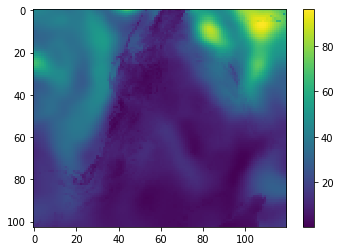

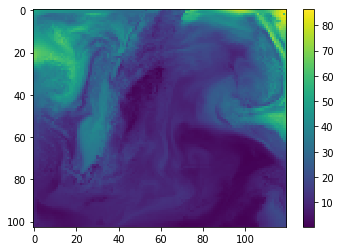

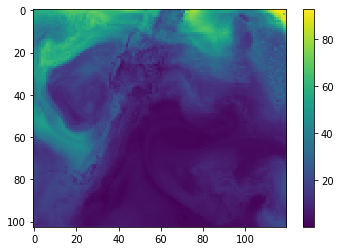

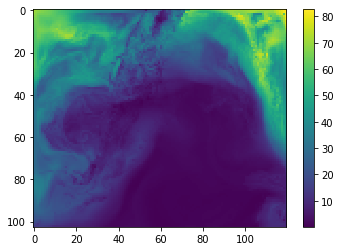

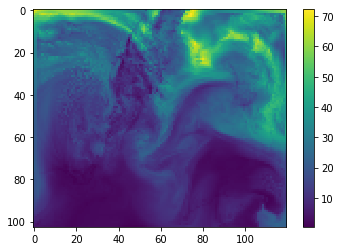

In [5]:
for i in range(0,100,20):
    plt.figure()
    plt.imshow(pwat_data_train.reshape(103,120,-1)[:,:,i])
    plt.colorbar()
    plt.show()